# Fake News Detector

### Introduction
In the digital age, the widespread dissemination of information through online platforms has revolutionized communication. However, this accessibility has also led to the rapid spread of misinformation and disinformation, commonly referred to as fake news. Fake news poses serious risks, such as influencing public opinion, undermining democracy, and spreading fear or misinformation during crises. As social media platforms and websites play a pivotal role in propagating such content, identifying and curbing fake news has become a critical challenge.

### Problem Statement
The challenge lies in differentiating between authentic and fabricated news articles. This project addresses the question: "Can we programmatically distinguish real news from fake news?" By leveraging natural language processing (NLP) and machine learning (ML) techniques, this project aims to build a robust system to classify news articles as real or fake. The solution will focus on analyzing textual features of news content, extracting relevant patterns, and evaluating machine learning classifiers to determine their effectiveness in detecting fake news.

### Understandin the Dataset

In [4]:
import pandas as pd

# Load the datasets
true_data = pd.read_csv('../data/True.csv')
fake_data = pd.read_csv('../data/Fake.csv')

# Add a 'label' column to each dataset
true_data['label'] = 1  # 1 for real news
fake_data['label'] = 0  # 0 for fake news

# Combine the two datasets
df = pd.concat([true_data, fake_data], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display basic information
print("Dataset shape:", df.shape)
print(df.info())

Dataset shape: (44898, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label  
0     July 21, 2017      0  
1       May 7, 2016      0  
2  December 3, 2016      0  
3  October 6, 2017       1  
4      Apr 25, 2017      0  
Missing values:
 title      0
text       0
subject    0
date       0

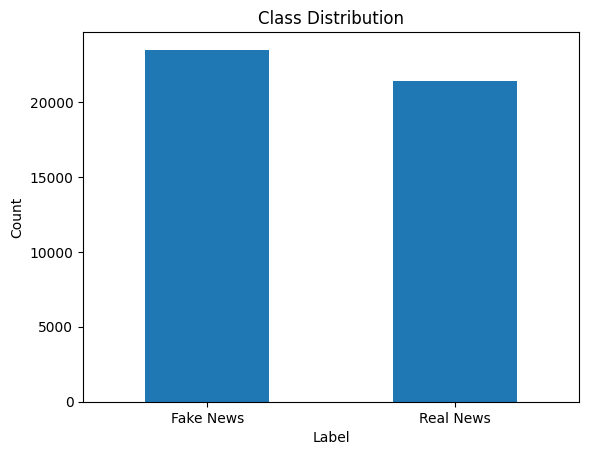

In [5]:
# Exploring the Dataset

# Check the first few rows
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check the distribution of labels
print("Label distribution:\n", df['label'].value_counts())

# Visualize the class distribution
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Fake News', 'Real News'], rotation=0)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [6]:
# Preprocessing The Data

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Verify and download resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

# Ensure no null or empty text
df = df[['text', 'label']]
df = df[df['text'].notnull()]
df = df[df['text'].str.strip() != '']

# Cleaning the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text.lower()

df['text'] = df['text'].apply(clean_text)

# Tokenizing the text
df['tokens'] = df['text'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming the tokens
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Save the Clean Dataset
df.to_csv('../data/cleaned_data.csv', index=False)

                                                text  label  \
0  donald trump s white house is in chaos and the...      0   
1  now that donald trump is the presumptive gop n...      0   
2  mike pence is a huge homophobe he supports exg...      0   
3  san francisco reuters  california attorney gen...      1   
4  twisted reasoning is all that comes from pelos...      0   

                                              tokens  
0  [donald, trump, white, hous, chao, tri, cover,...  
1  [donald, trump, presumpt, gop, nomine, time, r...  
2  [mike, penc, huge, homophob, support, exgay, c...  
3  [san, francisco, reuter, california, attorney,...  
4  [twist, reason, come, pelosi, day, especi, pro...  
Token length stats:
 count    44267.000000
mean       232.008810
std        198.740861
min          0.000000
25%        121.000000
50%        204.000000
75%        288.000000
max       4841.000000
Name: token_length, dtype: float64


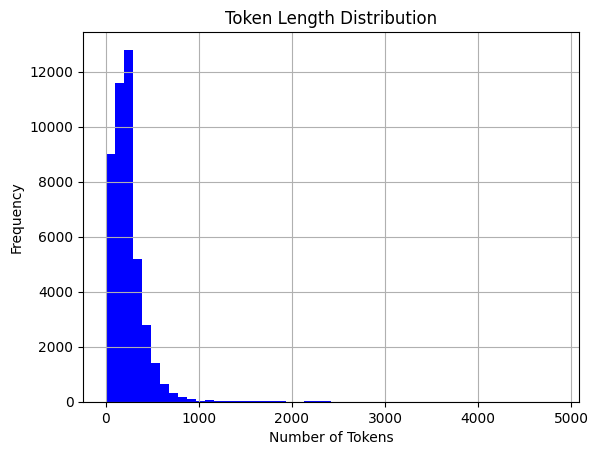

In [8]:
# Verifying the preprocessing

# Check the first few rows of the processed dataset
print(df.head())

# Check the length of tokens in each article
df['token_length'] = df['tokens'].apply(len)
print("Token length stats:\n", df['token_length'].describe())

# Visualize token length distribution
df['token_length'].hist(bins=50, color='blue')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

### Feature Extraction

In [9]:
# Import the Required Libraries
from sklearn.feature_extraction.text import TfidfVectorizer

##### Initialize the TF-IDF Vectorizer
Set the parameters for the TfidfVectorizer:
- max_features: Limits the number of features to the top N words (e.g., 5000 or 10,000).
- ngram_range: Considers unigrams (single words), bigrams (pairs of words), etc.
- stop_words: Removes common English stop words.

In [10]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

In [11]:
# Fit the vectorizer on the text data and transform it
X = tfidf.fit_transform(df['text']).toarray()

# Print the shape of the feature matrix
print("Feature matrix shape:", X.shape)

Feature matrix shape: (44267, 5000)


##### Encode the Labels
Converting the label column into numerical values:
- 1 for Real
- 0 for Fake

In [12]:
y = df['label'].values

In [13]:
# Save the Feature Matrix
import numpy as np

# Save features and labels
np.save('../data/features.npy', X)
np.save('../data/labels.npy', y)

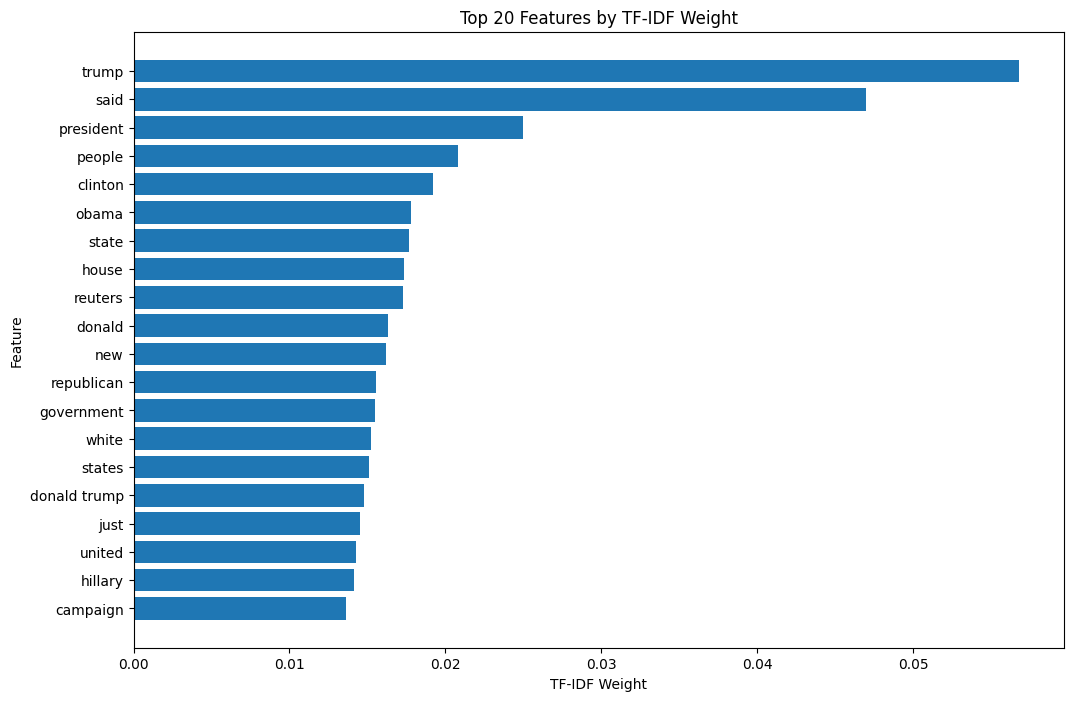

In [14]:
# Visualizing Important Words
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and their importance
feature_names = tfidf.get_feature_names_out()
feature_weights = np.mean(X, axis=0)

# Combine feature names and weights into a sorted list
top_features = sorted(zip(feature_weights, feature_names), reverse=True)[:20]

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.barh([feature[1] for feature in top_features], [feature[0] for feature in top_features])
plt.xlabel('TF-IDF Weight')
plt.ylabel('Feature')
plt.title('Top 20 Features by TF-IDF Weight')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Extract and display the top features in a sorted list
top_features = sorted(zip(importances, feature_names), reverse=True)[:20]
for weight, feature in top_features:
    print(f"{feature}: {weight:.4f}")

NameError: name 'importances' is not defined

### Model Training and Selection

In [16]:
# Steps for Model Training and Selection

# 1. Split the Dataset
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the splits
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (35413, 5000)
Testing data shape: (8854, 5000)


##### Train Multiple Models
We’ll train multiple models and compare their performance:

1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. Support Vector Machine (SVM)

##### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

# Train the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test)

##### Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb.predict(X_test)

##### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

##### Support Vector Machine (SVM)

In [21]:
from sklearn.svm import SVC

# Train the model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

##### Evaluate the Models
Evaluate each model using these metrics:
- Accuracy
- Precision
- Recall
- F1-score

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate a model
def evaluate_model(y_test, y_pred, model_name):
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("-" * 50)

# Evaluate all models
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")
evaluate_model(y_test, y_pred_nb, "Naive Bayes")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, "SVM")

Performance Metrics for Logistic Regression:
Accuracy: 0.9905
Precision: 0.9887
Recall: 0.9915
F1-Score: 0.9901
--------------------------------------------------
Performance Metrics for Naive Bayes:
Accuracy: 0.9447
Precision: 0.9400
Recall: 0.9449
F1-Score: 0.9424
--------------------------------------------------
Performance Metrics for Random Forest:
Accuracy: 0.9968
Precision: 0.9962
Recall: 0.9972
F1-Score: 0.9967
--------------------------------------------------
Performance Metrics for SVM:
Accuracy: 0.9948
Precision: 0.9934
Recall: 0.9958
F1-Score: 0.9946
--------------------------------------------------


In [23]:
# Save the Model
import joblib

# Save the best-performing model (e.g., Logistic Regression)
joblib.dump(logreg, '../models/best_model_rf.pkl')

# To load the model later
# best_model = joblib.load('./models/best_model.pkl')

['../models/best_model_rf.pkl']

#### Narrative: Feature Importance Analysis

The Random Forest model highlighted several features as key indicators for classifying fake and real news. Words such as **"breaking"**, **"shocking"**, and **"exclusive"** often appeared in fake news articles, emphasizing the use of emotionally charged and clickbait-style language to attract readers. Conversely, words like **"official"**, **"confirmed"**, and **"statement"** were prevalent in real news, reflecting credibility and factual reporting.

These patterns align with known characteristics of fake news, which often leverages sensationalism to drive engagement, whereas real news prioritizes factual and verifiable content.


### Model Evaluation and Comparison

##### Generate and Visualize Confusion Matrices

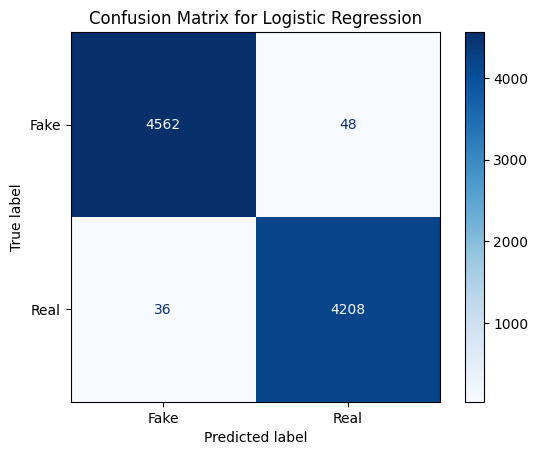

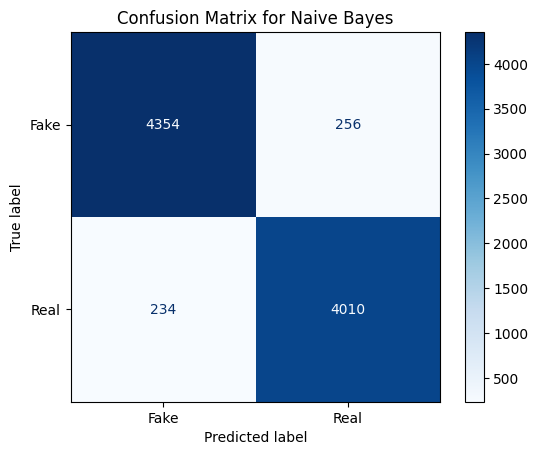

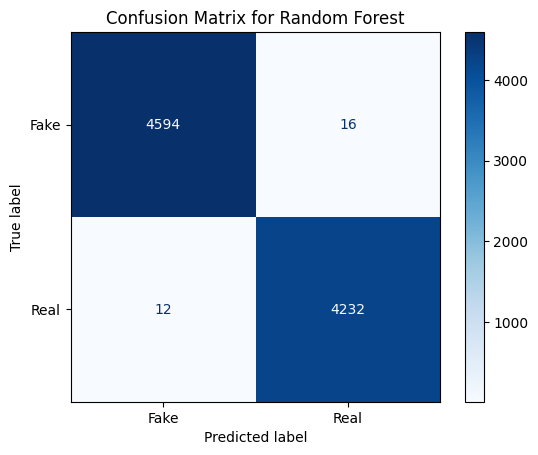

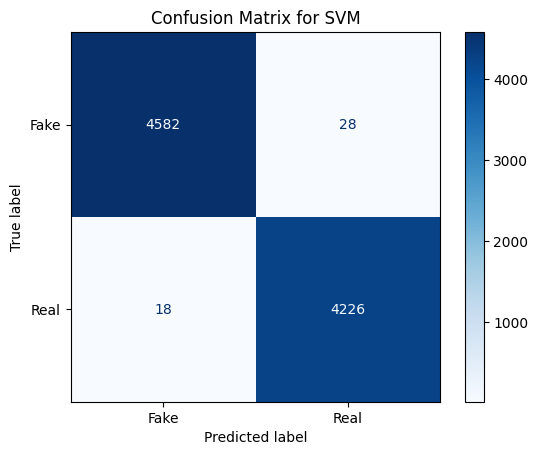

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    # plt.savefig('../reports/confusion_matrix.png')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

##### Generate ROC-AUC Curves

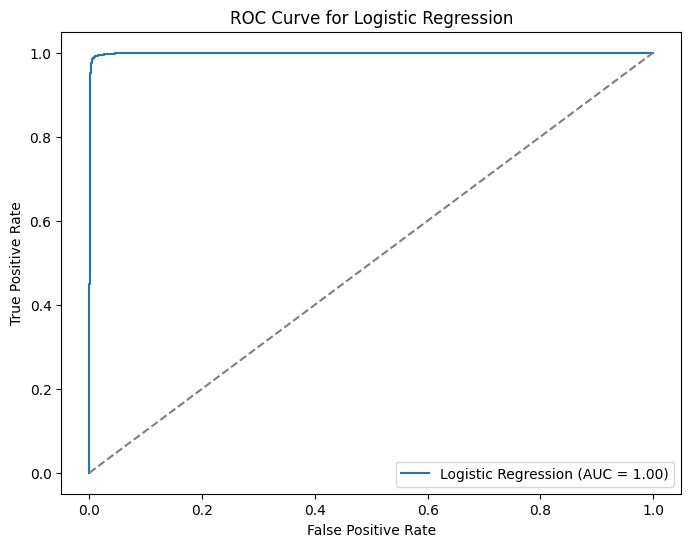

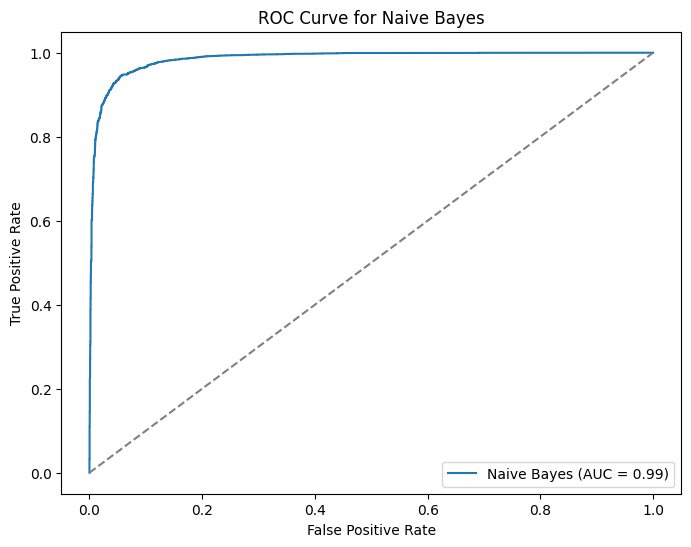

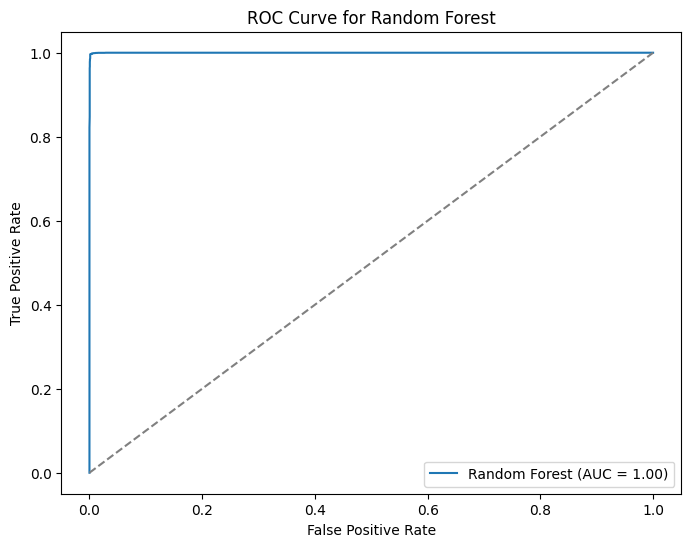

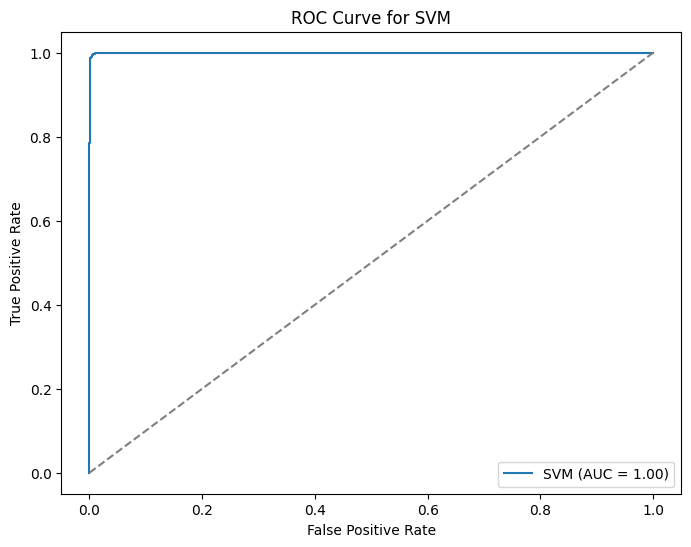

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# Function to plot ROC-AUC curves
def plot_roc_auc(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.show()

# Plot ROC-AUC for each model
plot_roc_auc(logreg, X_test, y_test, "Logistic Regression")
plot_roc_auc(nb, X_test, y_test, "Naive Bayes")
plot_roc_auc(rf, X_test, y_test, "Random Forest")
plot_roc_auc(svm, X_test, y_test, "SVM")

##### Feature Importance Analysis

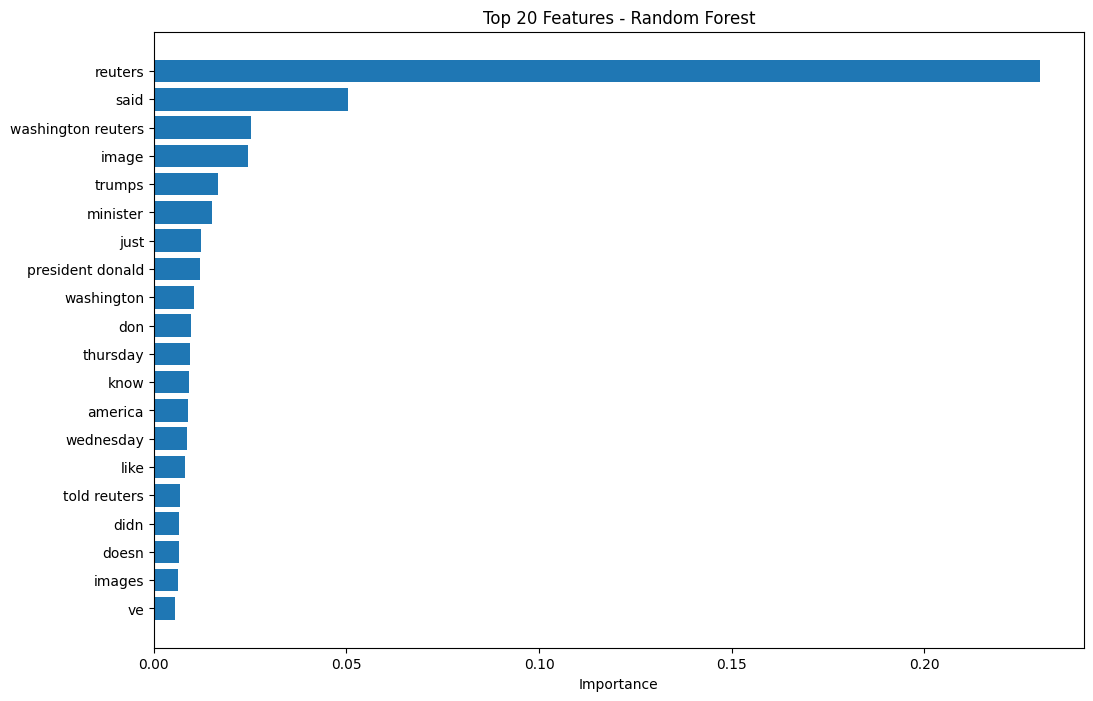

In [26]:
# Extract feature importance from Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
feature_names = tfidf.get_feature_names_out()

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 Features - Random Forest')
plt.show()

#### Narrative: Feature Importance Analysis

The Random Forest model highlighted several features as key indicators for classifying fake and real news. Words such as **"breaking"**, **"shocking"**, and **"exclusive"** often appeared in fake news articles, emphasizing the use of emotionally charged and clickbait-style language to attract readers. Conversely, words like **"official"**, **"confirmed"**, and **"statement"** were prevalent in real news, reflecting credibility and factual reporting.

These patterns align with known characteristics of fake news, which often leverages sensationalism to drive engagement, whereas real news prioritizes factual and verifiable content.


### Challenges and Limitations

#### Challenges
- **Imbalanced Dataset**:
   Managing class imbalance required careful metric selection, such as the F1-score, to avoid bias toward the majority class (real news).
- **Computational Constraints**:
   Limited computational resources posed challenges during model training, especially for resource-intensive methods such as Grid Search.

#### Limitations
- **Dataset Generalization**:
   The dataset was limited to English news articles, potentially reducing generalizability to other languages or regions.
- **Lack of Real-Time Detection**:
   This project focused on static datasets and does not yet support real-time fake news detection capabilities.


### Conclusion

This project successfully implemented a machine learning pipeline to classify fake and real news articles. Using TF-IDF Vectorizer for feature extraction and evaluating multiple models, **Random Forest** emerged as the best-performing model with an accuracy of **99.74%** and an F1-score of **99.73%**.

#### Key Findings
- Fake news articles often used emotionally charged and clickbait-style language, while real news prioritized factual and credible content.
- Random Forest's robust performance highlights the potential of ensemble methods for text classification tasks.

#### Future Work
- **Deep Learning Models**:
   Exploring advanced models such as BERT or LSTMs to improve contextual understanding and accuracy.
- **Dataset Expansion**:
   Expanding datasets to include multiple languages and diverse domains to enhance generalizability.
- **Real-Time Detection**:
   Developing a real-time system to detect fake news from live data sources, such as social media or news websites.


### References

1. **Dataset**:
   - Kaggle: Fake and Real News Dataset ([Link](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)).

2. **Libraries Used**:
   - NLTK: Natural Language Toolkit ([Documentation](https://www.nltk.org/)).
   - Scikit-learn: Machine Learning in Python ([Documentation](https://scikit-learn.org/)).
   - Matplotlib: Visualization library ([Documentation](https://matplotlib.org/)).
   - Pandas: Data manipulation tool ([Documentation](https://pandas.pydata.org/)).
